In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms
from torchvision.io import read_image
from model import RedCNN
from customDataset import CatdogDataset
import cv2
from misc import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import statistics

from PIL import Image
from IPython.display import display
import warnings
from sklearn.preprocessing import normalize
warnings.filterwarnings('ignore')

In [2]:
gtpath="../dogData_60/gt/"
gtfiles=[]
for folder, subfolder, filenames in os.walk(gtpath):
    for files in filenames:
        gtfiles.append(files)
        

noisepath="../dogData_60/noise/"
noisefiles=[]
for folder, subfolder, filenames in os.walk(noisepath):
    for files in filenames:
        noisefiles.append(files)
        
#check whether both noise and gt have same files
print(gtfiles==noisefiles)
gtfiles_=gtfiles[:1000]

True


In [3]:
m2dataset= CatdogDataset(data_path=noisepath,target_path=gtpath,filenames=gtfiles_)
train_size=int(0.7*len(m2dataset))
test_size=len(m2dataset)-train_size
trainset,testset=random_split(m2dataset,[train_size,test_size],generator=torch.manual_seed(42))


In [4]:

model_dog=RedCNN()
model_dog.load_state_dict(torch.load("./saved_models/task1_model.pth.tar"))
print(model_dog)
criterion=nn.MSELoss()
optimizer = torch.optim.Adam(model_dog.parameters(), lr=0.0001)


RedCNN(
  (conv1): Conv2d(1, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (d_conv1): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (d_conv2): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (d_conv3): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (d_conv4): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (d_output): ConvTranspose2d(96, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batchnorm): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [5]:
##Training
optimizer.zero_grad()


train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
test_loader = DataLoader(testset, batch_size=32, shuffle=True)


losses_batch=[]
trained_psnr=[]
psnr=[]
for epoch in range(3):
    
    for i, data in enumerate(train_loader):

        inputt, target=data

        target_pred=model_dog(inputt)
        
        img=inputt.detach().numpy()
        img_gt=target.detach().numpy()
        recon_image=target_pred.detach().numpy()
        
        
        for j in range(len(target)):
            psnr.append(cv2.PSNR(img[j],img_gt[j]))
            trained_psnr.append(cv2.PSNR(img[j],recon_image[j]))

        loss=criterion(target_pred,target)


        losses_batch.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"Epoch:{epoch} Loss:{loss.item()} Batch:{i}")


Epoch:0 Loss:1338.50244140625 Batch:0
Epoch:0 Loss:1249.0714111328125 Batch:1
Epoch:0 Loss:1245.9959716796875 Batch:2
Epoch:0 Loss:1179.594482421875 Batch:3
Epoch:0 Loss:1237.8909912109375 Batch:4
Epoch:0 Loss:1163.67431640625 Batch:5
Epoch:0 Loss:1173.51171875 Batch:6
Epoch:0 Loss:1120.30078125 Batch:7
Epoch:0 Loss:1106.6103515625 Batch:8
Epoch:0 Loss:1091.5445556640625 Batch:9
Epoch:0 Loss:1052.6434326171875 Batch:10
Epoch:0 Loss:1036.0543212890625 Batch:11
Epoch:0 Loss:1047.4326171875 Batch:12
Epoch:0 Loss:1012.0537109375 Batch:13
Epoch:0 Loss:1089.3826904296875 Batch:14
Epoch:0 Loss:1030.39599609375 Batch:15
Epoch:0 Loss:983.23876953125 Batch:16
Epoch:0 Loss:1028.3685302734375 Batch:17
Epoch:0 Loss:1002.80029296875 Batch:18
Epoch:0 Loss:1009.30712890625 Batch:19
Epoch:0 Loss:996.1875 Batch:20
Epoch:0 Loss:959.6297607421875 Batch:21
Epoch:1 Loss:953.8541870117188 Batch:0
Epoch:1 Loss:932.5667114257812 Batch:1
Epoch:1 Loss:910.3888549804688 Batch:2
Epoch:1 Loss:933.6627197265625 Batc

In [6]:

trained_psnrfile="./psnr_data/task2noewc_by_task2noewc_trainfiles.pth.tar"
psnr_file="./psnr_data/task2noewc_trainfiles.pth.tar"
loss_file="./saved_loss/task2noewc_loss.pth.tar"

torch.save(trained_psnr,trained_psnrfile)
torch.save(psnr,psnr_file)
torch.save(losses_batch,loss_file)
modelfile="./saved_models/task2noewc_model.pth.tar"

torch.save(model_dog.state_dict(),modelfile)

# Model Diagnostics

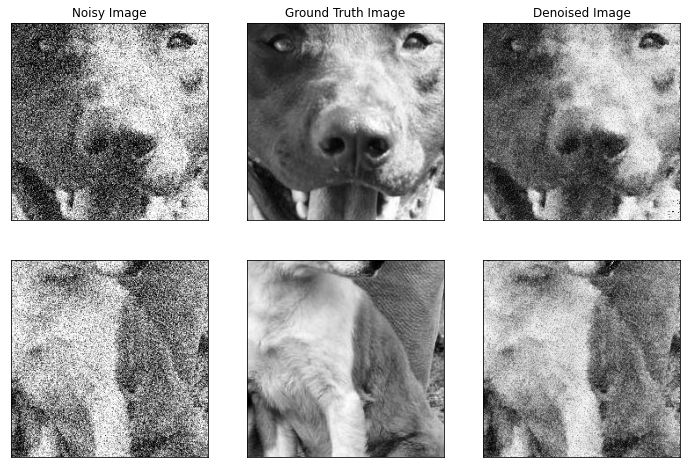

In [7]:
check_images(trainset[110],testset[9],model_dog)

ValueError: x and y must have same first dimension, but have shapes (22,) and (66,)

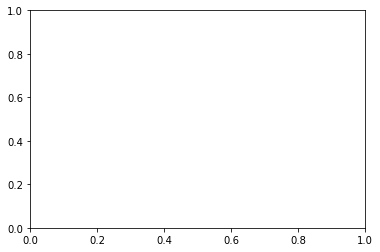

In [8]:
#plopling the loss vs batch
plt.plot(list(range(22)),losses_batch)

In [ ]:
##PSNR of training data
print(f"PSNR Training Set: {statistics.mean(psnr)}")
print(f"PSNR after applying the model: {statistics.mean(trained_psnr)}")

In [ ]:
##PSNR of test data
test_psnrfile="./psnr_data/task2noewc_testfiles.pth.tar"
test_modelpsnrfile="./psnr_data/task2noewc_by_task2noewc_testfiles.pth.tar"

test1_psnr=gt_psnr(testset)
test_modelpsnr=test_psnr(testset,model_dog)

torch.save(test1_psnr,test_psnrfile)
torch.save(test_modelpsnr,test_modelpsnrfile)

In [ ]:
task1model=RedCNN()
task1model.load_state_dict(torch.load("./saved_models/task1_model.pth.tar"))

In [ ]:
test_cl2modelpsnrfile="./psnr_data/task2_by_task1_testfiles.pth.tar"
test_cl2modelpsnr=test_psnr(testset,task1model)

torch.save(test_cl2modelpsnr,test_cl2modelpsnrfile)